In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Збір даних

Перш за все, потрібно зібрати дані з акселерометра мобільного телефону.
<center><img src="image.png"/></center>


In [2]:
from pathlib import Path
activities = ['idle', 'running', 'stairs', 'walking']
data_collections = []

for index, activity in enumerate(activities, start=1):
    activity_path = Path('data') / activity  
    csv_files = list(activity_path.glob('*.csv'))  
    df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)
    df['activity'] = activity
    data_collections.append(df)

data = pd.concat(data_collections, ignore_index=True)
data

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,1.000776,4.616021,8.576031,idle
1,0.718261,4.209007,8.446744,idle
2,-0.909797,-0.282516,9.203311,idle
3,5.099650,0.148441,8.418014,idle
4,1.762132,-0.162806,9.251195,idle
...,...,...,...,...
193855,5.109226,-15.452178,-1.470040,walking
193856,6.373365,-11.741165,-8.226476,walking
193857,3.289633,-9.993398,-0.383072,walking
193858,-2.978387,-3.050213,1.273715,walking


# Тренування на вихідних нормалізованих данних

В якості характеристик візьмемо показники з акселерометра

In [3]:
features = ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']

## Нормалізація даних

Тренування на ненормаліованих даних займає чимало часу. Вхідні дані нормалізуються так, щоб їхнє середнє значення дорівнювало нулю, а стандартне відхилення - одиниці. 

In [4]:
scaler = StandardScaler()

data_to_normalize = data[features]

# Нормалізація даних
normalized_data = scaler.fit_transform(data_to_normalize)

# Заміна вихідних даних нормалізованими даними
ndata = data.copy()
ndata[features] = normalized_data
ndata

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,-0.109791,0.241917,0.941538,idle
1,-0.143404,0.209288,0.923560,idle
2,-0.337109,-0.150782,1.028762,idle
3,0.377889,-0.116234,0.919565,idle
4,-0.019205,-0.141185,1.035420,idle
...,...,...,...,...
193855,0.379029,-1.366884,-0.455385,walking
193856,0.529435,-1.069384,-1.394879,walking
193857,0.162535,-0.929271,-0.304241,walking
193858,-0.583227,-0.372659,-0.073862,walking


## Розділяємо дані

Розділяємо датасет на навчальний і тестовий набори

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data["activity"],
    test_size=0.3,
    stratify=ndata["activity"],
)

## Навчаємо за допомогою алгоритму SVM

In [6]:
%%time

model_svm = SVC()
model_svm.fit(X_train, y_train)

CPU times: total: 5min 7s
Wall time: 5min 52s


SVC()

## Навчаємо за допомогою алгоритму випадкового лісу

In [7]:
%%time

model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

CPU times: total: 13.3 s
Wall time: 14.5 s


RandomForestClassifier()

## Порівнюємо точність результатів

Визначаємо точність моделей на тестовому наборі та порівнюємо

In [8]:
score_svm = model_svm.score(X_test, y_test)
score_rf = model_rf.score(X_test, y_test)

print(f"Точність моделі SVM: {score_svm:.2f}")
print(f"Точність моделі випадкового лісу: {score_rf:.2f}")

Точність моделі SVM: 0.89
Точність моделі випадкового лісу: 1.00


# Тренування на підготовленних даних

## Вибираємо ознаки

В [статті](https://www.sciencedirect.com/science/article/pii/S1877050916322153) [1] пропонується обрати наступні часові ознаки (таблиця 3). Як пишуть автори, їхні результати показують, що найбільш репрезентативні ознаки отримані з часового представлення сигналу акселерометра. Ознаки, витягнуті з сигналів по осях $x$ і $y$ є більш релевантними, ніж ознаки по осі $z$ при визначенні активності. 

| Name                          | Axis |
| ----------------------------- | ---- |
| Maximum Value                 |   x  |
| Minimum Value                 |   x  |
| Entropy                       |   x  |
| Interquartile Range           |   x  |
| Maximum Value                 |   y  |
| Index of Minimum Value        |   y  |
| Mean of Absolute Deviation    |   y  |
| Median                        |   y  |
| Skewness                      |   y  |
| Standard Deviation            |   y  |
| Root Mean Square Error        |   y  |
| Skewness                      |   z  |

## Створення необхідних функцій

In [9]:
def iqr(data):
    """Calculates the interquartile range (IQR) of a dataset.

    The IQR is the difference between the 75th and 25th percentiles of the data,
    and is a measure of the spread of the middle 50% of the data.

    Args:
        data: A NumPy array or Pandas Series containing the data.

    Returns:
        The IQR of the data.
    """
    sorted_data = np.sort(data)
    
    Q1 = np.percentile(sorted_data, 25)
    Q3 = np.percentile(sorted_data, 75)
    
    IQR = Q3 - Q1
    
    return IQR
  
def argmin(data):
    """Returns the index of the minimum value in a dataset.

    Args:
        data: A NumPy array or Pandas Series containing the data.

    Returns:
        The index of the minimum value in the data.
    """
    return np.argmin(data)

def entropy(column_data):
    """Calculates the entropy of a column of data.

    Entropy is a measure of uncertainty or randomness in a set of data. It is calculated as follows:

    ```
    H = -sum(pk * log2(pk))
    ```

    where pk is the probability of each value in the data set.

    Args:
        column_data: A NumPy array or Pandas Series containing the data.

    Returns:
        The entropy of the data.
    """
    
    hist, bins = np.histogram(column_data, bins='auto')
    probs = hist / len(column_data)

    probs = probs[probs > 0]

    entropy = -np.sum(probs * np.log2(probs))

    return entropy

def mad(data):
    """Calculates the median absolute deviation (MAD) of a dataset.

    The MAD is a measure of the spread of the data, and is calculated as the median of the absolute deviations from the median. It is a more robust measure of spread than the standard deviation, as it is less sensitive to outliers.

    Args:
        data: A NumPy array or Pandas Series containing the data.

    Returns:
        The MAD of the data.
    """
    mean = np.mean(data)
    
    absolute_deviations = np.abs(data - mean)
    
    mad = np.mean(absolute_deviations)
    
    return mad

def rmse(data):
    """Calculates the root mean square error (RMSE) of a dataset.

    The RMSE is a measure of the average difference between the actual values in the dataset and the predicted values. It is calculated as follows:

    ```
    RMSE = sqrt(mean((y_true - y_pred)**2))
    

    where:

    * `y_true` is the actual values in the dataset
    * `y_pred` is the predicted values

    The RMSE is a good measure of fit for regression models, and is often used to evaluate the performance of a model on a held-out test set.

    Args:
        data: A NumPy array or Pandas Series containing the data.

    Returns:
        The RMSE of the data.
    """
    
    mean = np.mean(data)
    
    squared_errors = [(x - mean) ** 2 for x in data]
    
    rmse = np.sqrt(np.mean(squared_errors))
    
    return rmse

## Створення датасету на основі ознак, вказанних в статті

In [10]:
data_tdf = ndata.copy()

stat_features = ["max", "min", entropy, iqr, argmin, mad, "median", "skew", "std", rmse]

data_tdf = (
    data.groupby(["activity", data.index // 30]).agg(stat_features).reset_index(level=0)
)

In [11]:
# Видалимо ознаки, які не релевантні для аналізу з точки зору авторів вказаної статті [1]

data_tdf.drop(
    [
        ("accelerometer_X", "argmin"),
        ("accelerometer_X", "mad"),
        ("accelerometer_X", "median"),
        ("accelerometer_X", "skew"),
        ("accelerometer_X", "std"),
        ("accelerometer_X", "rmse"),
        ("accelerometer_Y", "iqr"),
        ("accelerometer_Y", "min"),
        ("accelerometer_Y", "entropy"),
        ("accelerometer_Y", "iqr"),
        ("accelerometer_Z", "max"),
        ("accelerometer_Z", "min"),
        ("accelerometer_Z", "entropy"),
        ("accelerometer_Z", "iqr"),
        ("accelerometer_Z", "argmin"),
        ("accelerometer_Z", "mad"),
        ("accelerometer_Z", "median"),
        ("accelerometer_Z", "std"),
        ("accelerometer_Z", "rmse")
    ],
    axis=1,
    inplace=True
)

In [12]:
# Утворений датасет на основі ознак таблиці 3 статті [1]

data_tdf

activity accelerometer_X                               accelerometer_Y  \
                          max       min   entropy       iqr             max   
0        idle        5.099650 -0.909797  3.075701  0.065840        4.616021   
1        idle        0.407014 -0.320823  2.732915  0.039505        0.023942   
2        idle       -0.062249 -0.124498  2.389898  0.021548        0.244209   
3        idle        0.560243  0.268151  2.663458  0.050279        0.086191   
4        idle        0.560243  0.268151  2.384778  0.051476        0.086191   
...       ...             ...       ...       ...       ...             ...   
6457  walking        7.192182 -5.990292  2.507218  5.601235        0.181959   
6458  walking        7.192182 -7.359776  2.421421  5.035007        0.181959   
6459  walking       11.113884 -7.359776  2.295601  5.007473        0.181959   
6460  walking       11.113884 -7.359776  2.441946  4.416105        0.181959   
6461  walking       11.113884 -7.359776  2.380542  6.479907        0.181959   

                                                               accelerometer_Z  
     argmin       mad     median      skew       std      rmse            skew  
0         2  0.566011  -0.131681  3.647470  1.157603  1.138147       -2.365312  
1         7  0.028411  -0.131681  0.568223  0.048059  0.047251       -2.409922  
2        14  0.012045   0.225055 -1.272920  0.016383  0.016108       -0.097477  
3        28  0.037882  -0.021548 -0.857829  0.054525  0.053608        0.565957  
4        26  0.036818  -0.019154 -1.001079  0.054004  0.053096        0.453139  
...     ...       ...        ...       ...       ...       ...             ...  
6457     18  4.100150 -10.414777 -0.540493  5.285310  5.196475        1.221757  
6458     16  4.176020 -10.414777 -0.523121  5.329992  5.240406        1.178148  
6459     14  4.327631 -10.414777 -0.453662  5.412533  5.321559        1.996085  
6460     12  4.135180 -10.747571 -0.365569  5.294201  5.205216        1.959435  
6461     10  4.237003 -10.414777 -0.354875  5.443090  5.351603        1.950320  

[6462 rows x 13 columns]

## Розділяємо датасет на навчальний і тестовий набори

In [13]:

X_train, X_test, y_train, y_test = train_test_split(
    data_tdf[features], data_tdf["activity"],
    test_size=0.3,
    stratify=data_tdf["activity"],
)

## Навчаємо за домомогою алгоритму `SVN`

In [14]:
%%time

model_svm = SVC()
model_svm.fit(X_train, y_train)

CPU times: total: 46.9 ms
Wall time: 59 ms


SVC()

## Навчаємо за домомогою алгоритму `random forest`

In [15]:
%%time

model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

CPU times: total: 844 ms
Wall time: 933 ms


RandomForestClassifier()

## Визначаємо точність моделей на тестовому наборі

In [ ]:
score_svm = model_svm.score(X_test, y_test)
score_rf = model_rf.score(X_test, y_test)

print(f"Точність моделі SVM: {score_svm:.2f}")
print(f"Точність моделі випадкового лісу: {score_rf:.2f}")

Точність моделі SVM: 0.97
Точність моделі випадкового лісу: 1.00


## Пргнозування

In [21]:
y_predicted_svm = model_svm.predict(X_test)
y_predicted_rf = model_rf.predict(X_test)

Побудуємо матрицю помилок `confusion matrix` - таблицю, яка показує, як часто класифікатор правильно класифікує позитивні та негативні приклади.

In [37]:
conf_matrix_svm = confusion_matrix(y_test, y_predicted_svm)
conf_matrix_rf = confusion_matrix(y_test, y_predicted_rf)

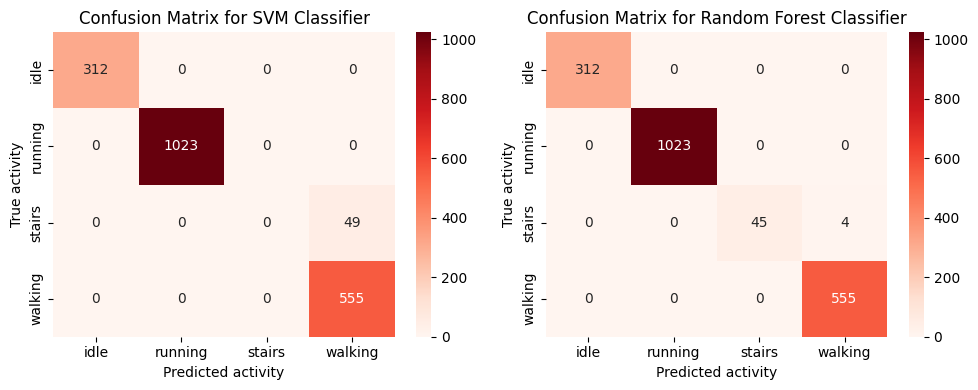

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

classifiers = ["SVM", "Random Forest"]
confusion_matrices = [conf_matrix_svm, conf_matrix_rf]

for i, classifier in enumerate(classifiers):
    sns.heatmap(
        confusion_matrices[i],
        annot=True,
        fmt='d',
        cmap='Reds',
        xticklabels=activities,
        yticklabels=activities,
        ax=axes[i],
    )
    axes[i].set_title(f"Confusion Matrix for {classifier} Classifier")
    axes[i].set_xlabel("Predicted activity")
    axes[i].set_ylabel("True activity")

plt.tight_layout()

plt.show()

- Як видно, класифікатор `SVM` помилився в 49 випадках, класифікувавши ходіння по сходах (`stairs`) як прогулянку (`walking`).

- Класифікатор `ramdom forest` помилився в 4 випадках, класифікувавши ходіння по сходах (`stairs`) як прогулянку (`walking`).

# Результати та висновки


1. Для навчання алгоритму `SVN` на __вихідних ознаках__ (показах акселерометра по трьох осях) потрібно близько 20 хвилин на стандартному комп'ютері. Навчання на вихідних ознаках (показах акселерометра по трьох осях) спричиняє довге навчання, оскільки алгоритм `SVN` має велику кількість параметрів, які потрібно оптимізувати. Це пов'язано з тим, що алгоритм `SVN` намагається знайти оптимальну підмножину ознак, яка найкраще класифікує дані. У випадку з даними про рух людини, які мають багато шуму і невизначеності, це може бути дуже складним завданням.

2. Навчання на __нормалізованих ознаках__ акселерометра по трьох осях зменшує час навчання алгоритму `SVN` до близько 4 хвилин. Навчання на нормалізованих показах акселерометра по трьох осях дає значний виграш при навчання по методу `SVN`, оскільки це зменшує кількість параметрів, які потрібно оптимізувати. Нормування показів акселерометра по трьох осях усуває масштабування, яке може призвести до переваги одних ознак над іншими. Це також робить дані більш однорідними, що полегшує задачу навчання алгоритму `SVN`.
    - час розрахунку близько 4 хвилин;
    - точність 0.89.

3. Навчання за методом випадкового лісу показує кращу точність та набагато менший час навчання, оскільки це більш стійкий до шуму і невизначеності алгоритм. Метод випадкового лісу генерує декілька дерев рішень, і кожен з них голосує за класифікацію. Це дозволяє алгоритму випадкового лісу бути більш точним, ніж алгоритм `SVN`, який генерує лише одне дерево рішень. Крім того, метод випадкового лісу має набагато меншу кількість параметрів, ніж алгоритм `SVN`, що також сприяє його більш швидкому навчанню.
    - час розрахунку близько 13 секунд;
    - точність 1.00.

4. Навчання, де в якості ознак взяті статистичні ознаки запропоновані в [статті](https://www.sciencedirect.com/science/article/pii/S1877050916322153) [1], отримані по набору з 30 показників акселерометра для кожної осі $x$, $y$ та $z$ показує:
    - точність моделі `SVM` значно підвищилась до значення 0.975, крім того час навчання значно зменшився і становить 46.9 ms.
    - точність моделі `random forest` дещо знизилась в порівнянні з навчанням на вихідних нормалізованих даних до величини 0.994, час навчання становить 766 ms, що значно менше ніж для навчання на вихідних нормалізованих даних, але натомість він значно вище в порявнянні з моделлю `SVN`.

Таблиця з результатами

<center>
<table>
<caption>Таблиця. Результати</caption>
<thead>
  <tr>
    <th>Тип ознак</th>
    <th>Алгоритм</th>
    <th>Час розрахунку</th>
    <th>Точність</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td rowspan="2">вихідні нормалізовані</td>
    <td>SVN</td>
    <td>240 s</td>
    <td>0.89</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>13 s</td>
    <td>1.00</td>
  </tr>
  <tr>
    <td rowspan="2">статистичні дані</td>
    <td>SVN</td>
    <td>46.9 ms</td>
    <td>0.98</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>766 ms</td>
    <td>0.99</td>
  </tr>
</tbody>
</table>
</center>

Згідно таблиці, можна зробити висновок, що найкращі результати дає в сенсі час/чточність дає алгоритм `random forest`, який тренувався не на вихідних, а на статистичних ознаках. Ці висновки також підтверджуються аналізом матриці помилок, показує, що класифікатор `random forest` помиляється значно менше, ніж `SVM`.

# Посилання

[1]: Ç.Berke Erdaş, Işıl Atasoy, Koray Açıcı, Hasan Oğul, Integrating Features for Accelerometer-based Activity Recognition,
Procedia Computer Science, Volume 98, 2016, Pages 522-527, ISSN 1877-0509, https://doi.org/10.1016/j.procs.2016.09.070.